<a href="https://colab.research.google.com/github/Ihsanalmasry/MachingLearning_Lab4_IHSAN-ALMASRY/blob/main/MLF_FinalProject_IHSAN%20ALMASRY.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install -q keras-tuner

In [3]:
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization, Input
import keras_tuner as kt
import matplotlib.pyplot as plt



In [4]:
# STEP 1: LOAD DATA
def load_data(train_folder, test_folder, label_file):
    labels_df = pd.read_csv(label_file)

    # Training data
    X_train, y_train = [], []
    for _, row in labels_df.iterrows():
        filename = f"{row['ID']}.npy"  # assumes the file is like 0.npy, 1.npy, ...
        x = np.load(os.path.join(train_folder, filename))
        X_train.append(x)
        y_train.append(row['target'])  # match the 'target' column
    X_train = np.array(X_train)
    y_train = np.array(y_train)

    # Test data
    test_files = sorted(os.listdir(test_folder))
    X_test = [np.load(os.path.join(test_folder, f)) for f in test_files]
    X_test = np.array(X_test)

    return X_train, y_train, X_test, test_files


In [5]:
# STEP 2: PREPROCESSING
def preprocess_data(X_train, y_train, X_test, use_1D=False):
    X_train = X_train / np.max(X_train)
    X_test = X_test / np.max(X_test)

    if use_1D:
        X_train = X_train.reshape(X_train.shape[0], -1)
        X_test = X_test.reshape(X_test.shape[0], -1)
    else:
        X_train = X_train[..., np.newaxis]
        X_test = X_test[..., np.newaxis]

    y_train = to_categorical(y_train, num_classes=3)

    return X_train, y_train, X_test



In [6]:
# STEP 3A: CNN MODEL
def build_cnn_model(input_shape):
    model = Sequential([
        Input(shape=input_shape),
        Conv2D(32, (3,3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(2,2),
        Conv2D(64, (3,3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(2,2),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.4),
        Dense(3, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model



In [7]:
# STEP 3B: DNN MODEL
def build_dnn_model(input_shape):
    model = Sequential([
        Input(shape=(input_shape,)),
        Dense(256, activation='relu'),
        Dropout(0.3),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(3, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [8]:
# STEP 4: HYPERPARAMETER TUNING
def model_builder(hp, input_shape, use_1D=False):
    model = Sequential()
    model.add(Input(shape=input_shape))

    if use_1D:
        for i in range(hp.Int("layers", 1, 3)):
            model.add(Dense(units=hp.Int(f"units_{i}", 64, 256, step=64), activation='relu'))
            model.add(Dropout(hp.Float(f"dropout_{i}", 0.2, 0.5)))
    else:
        for i in range(hp.Int("conv_layers", 1, 2)):
            model.add(Conv2D(filters=hp.Int(f"filters_{i}", 32, 128, step=32),
                             kernel_size=(3, 3), activation='relu'))
            model.add(BatchNormalization())
            model.add(MaxPooling2D(2, 2))
        model.add(Flatten())
        model.add(Dense(hp.Int("dense_units", 64, 256, step=64), activation='relu'))
        model.add(Dropout(hp.Float("dropout_final", 0.2, 0.5)))

    model.add(Dense(3, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [9]:
# STEP 5: TRAINING & EVALUATION
def train_and_evaluate(X_train, y_train, X_test, test_files, use_1D=False, use_tuning=False):
    X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

    # Correctly handle input_shape when using 1D data
    if use_1D:
        input_shape = (X_tr.shape[1],)  # Ensure it's treated as 1D input
    else:
        input_shape = X_tr.shape[1:]  # For CNN, retain the original 3D shape

    if use_tuning:
        tuner = kt.RandomSearch(
            lambda hp: model_builder(hp, input_shape, use_1D),
            objective='val_accuracy',
            max_trials=5,
            directory='tuner_results',
            project_name='fbs_detection'
        )
        tuner.search(X_tr, y_tr, epochs=10, validation_data=(X_val, y_val))
        model = tuner.get_best_models(num_models=1)[0]
    else:
        # Using DNN or CNN based on `use_1D`
        if use_1D:
            model = build_dnn_model(input_shape)
        else:
            model = build_cnn_model(input_shape)

    model.summary()
    history = model.fit(X_tr, y_tr, epochs=20, batch_size=32, validation_data=(X_val, y_val))

  # PLOT TRAINING HISTORY
    plt.figure(figsize=(12, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.savefig("training_curves.png")
    plt.show()


# CONFUSION MATRIX & REPORT
    preds_val = model.predict(X_val)
    y_true = np.argmax(y_val, axis=1)
    y_pred = np.argmax(preds_val, axis=1)

    print("Validation Report:\n", classification_report(y_true, y_pred))

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.savefig("confusion_matrix.png")
    plt.show()

    # Predict and save final submission
    preds_test = model.predict(X_test)
    final_preds = np.argmax(preds_test, axis=1)

    submission = pd.DataFrame({'FileName': test_files, 'PredictedLabel': final_preds})
    submission.to_csv("submission.csv", index=False)
    print("Saved submission.csv")



    #preds_val = model.predict(X_val)
    #print("Validation Report:\n", classification_report(np.argmax(y_val, axis=1), np.argmax(preds_val, axis=1)))

    #preds_test = model.predict(X_test)
    #final_preds = np.argmax(preds_test, axis=1)

    #submission = pd.DataFrame({'FileName': test_files, 'PredictedLabel': final_preds})
    #submission.to_csv("submission.csv", index=False)
    #print("Saved submission.csv")



In [10]:
# MAIN PIPELINE FUNCTION
def run_pipeline(train_folder, test_folder, label_file, use_1D=False, use_tuning=False):
    X_train, y_train, X_test, test_files = load_data(train_folder, test_folder, label_file)
    X_train, y_train, X_test = preprocess_data(X_train, y_train, X_test, use_1D=use_1D)
    train_and_evaluate(X_train, y_train, X_test, test_files, use_1D=use_1D, use_tuning=use_tuning)


In [11]:
# SETTING PATHS
base_path = '/content/drive/MyDrive/MPA-MLF_DATA_NEW'
train_folder = os.path.join(base_path, 'Train')
test_folder = os.path.join(base_path, 'Test')
label_file = os.path.join(base_path, 'label_train.csv')


Trial 5 Complete [00h 01m 42s]
val_accuracy: 0.12709030508995056

Best val_accuracy So Far: 0.9698996543884277
Total elapsed time: 00h 15m 36s


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 70, 46, 96)     │           960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 70, 46, 96)     │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 35, 23, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 77280)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     4,945,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,947,523 (18.87 MB)

 Trainable params: 4,947,331 (18.87 MB)

 Non-trainable params: 192 (768.00 B)

Epoch 1/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 18s 422ms/step - accuracy: 0.9694 - loss: 0.0804 - val_accuracy: 0.9298 - val_loss: 0.5133
Epoch 2/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 24s 640ms/step - accuracy: 0.9845 - loss: 0.0289 - val_accuracy: 0.9900 - val_loss: 0.1160
Epoch 3/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 33s 425ms/step - accuracy: 0.9878 - loss: 0.0226 - val_accuracy: 0.9799 - val_loss: 0.0729
Epoch 4/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 22s 458ms/step - accuracy: 0.9851 - loss: 0.0426 - val_accuracy: 0.9398 - val_loss: 0.1825
Epoch 5/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 19s 427ms/step - accuracy: 0.9761 - loss: 0.0710 - val_accuracy: 0.9833 - val_loss: 0.0501
Epoch 6/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 21s 444ms/step - accuracy: 0.9972 - loss: 0.0101 - val_accuracy: 0.9231 - val_loss: 0.4551
Epoch 7/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 20s 424ms/step - accuracy: 0.9946 - loss: 0.0194 - val_accuracy: 0.9465 - val_loss: 0.1582
Epoch 8/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 20s 423ms/step - accuracy: 0.9924 - loss: 0.0175 - val_accu

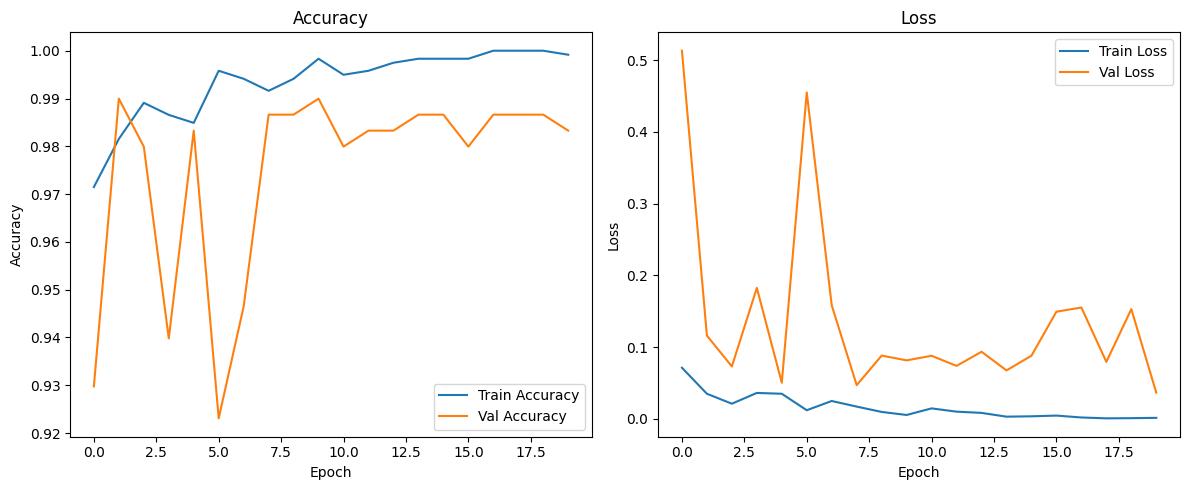

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step
Validation Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       234
           1       0.90      0.97      0.94        38
           2       0.96      0.85      0.90        27

    accuracy                           0.98       299
   macro avg       0.95      0.94      0.95       299
weighted avg       0.98      0.98      0.98       299



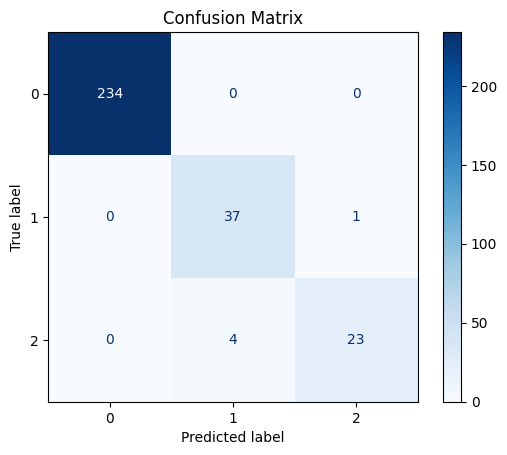

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Saved submission.csv


In [12]:
# RUNING CONFIGURATION

## Option 1: CNN without tuning
#run_pipeline(train_folder, test_folder, label_file, use_1D=False, use_tuning=False)

## Option 2: CNN with tuning
run_pipeline(train_folder, test_folder, label_file, use_1D=False, use_tuning=True)

## Option 3: DNN without tuning
#run_pipeline(train_folder, test_folder, label_file, use_1D=True, use_tuning=False)

## Option 4: DNN with tuning
#run_pipeline(train_folder, test_folder, label_file, use_1D=True, use_tuning=True)